# Run analyses on multiple polygons

* **Products used:** 
[ s2_l2a](https://explorer.digitalearth.africa/s2_l2a)

## Background
Many users need to run analyses on their own areas of interest. 
A common use case involves running the same analysis across multiple polygons in a vector file (e.g. ESRI Shapefile or GeoJSON). 
This notebook will demonstrate how to use a vector file and the Open Data Cube to extract satellite data from Digital Earth Africa to match individual polygon geometries.

## Description
If we have a vector file containing multiple polygons, we can use the python package [geopandas](https://geopandas.org/) to open it as a `GeoDataFrame`. 
We can then iterate through each geometry and extract satellite data corresponding with the extent of each geometry. 
Further anlaysis can then be conducted on each resulting `xarray.Dataset`.

In this notebook, we demonstrate how to retrieve data for each polygon and perform an analysis.
The example analysis in this notebook is to load and plot the normalised difference vegetation index (NDVI).
This is conducted through the following steps:

1. Open the file of polygons using `geopandas`.
2. Iterate through the generated GeoDataFrame, extracting satellite data from DE Africa's Open Data Cube.
3. Calculate NDVI as an example analysis on one of the extracted satellite timeseries.
4. Plot NDVI for the polygon extent.

***


## Getting started
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Please note the use of `datacube.utils` package `geometry`: 
this is important for saving the coordinate reference system of the incoming shapefile in a format that the Digital Earth Africa query can understand.

In [1]:
%matplotlib inline

# Force GeoPandas to use Shapely instead of PyGEOS
# In a future release, GeoPandas will switch to using Shapely by default.
import os
os.environ['USE_PYGEOS'] = '0'

import datacube
import matplotlib.pyplot as plt
import geopandas as gpd
from datacube.utils import geometry

from deafrica_tools.datahandling import load_ard
from deafrica_tools.bandindices import calculate_indices
from deafrica_tools.plotting import rgb, map_shapefile
from deafrica_tools.spatial import xr_rasterize
from deafrica_tools.classification import HiddenPrints

### Connect to the datacube
Connect to the datacube database to enable loading Digital Earth Australia data.

In [2]:
dc = datacube.Datacube(app='Analyse_multiple_polygons')

## Analysis parameters

* `time_range` : Enter a time range for your query, e.g.`('2019-01', '2019-12')` if you wanted data from all of 2019
* `vector_file` : A path to a vector file (ESRI Shapefile or GeoJSON) containing polygons to load. For this example we have provided a demonstration Shapefile
* `attribute_col` : A column in the vector file used to label the output `xarray` datasets containing satellite images. Each row of this column should have a unique identifier
* `products` : A list of product names to load from the datacube, e.g. `['ls8_c2l2', 'ls7_c2l2']`. In this example we will use only Sentinel-2 data, `['s2_l2a']`
* `measurements` : A list of band names to load from the satellite product, e.g. `['red', 'green']`
* `resolution` : The spatial resolution of the loaded satellite data in the `x` and `y` directions in metres. For this Sentinel-2 example, we have selected `(-20, 20)`
* `output_crs` : The coordinate reference system/map projection to load data into, e.g. `'EPSG:6933'` to load data in an Equal Area projection for Africa

In [3]:
time_range = ('2019-04', '2019-07')

vector_file = '../Supplementary_data/Analyse_multiple_polygons/multiple_polygons.shp'
attribute_col = 'id'

products = ['s2_l2a']
measurements = ['red', 'green', 'blue', 'nir']
resolution = (-20, 20)
output_crs = 'EPSG:6933'

### Look at the structure of the vector file
Import the file and take a look at how the file is structured so we understand what we are iterating through. 
There are three polygons in the file:

We will also update the `id` column to give each polygon a unique identifier. This will be used to identify the satelllite data corresponding with the polygon in the results dictionary

In [4]:
#read shapefile
gdf = gpd.read_file(vector_file)

# add an ID column
gdf['id']=range(0, len(gdf))

#print gdf
gdf.head()

,id,class,geometry
0,0,0,"POLYGON ((-0.55603 7.66642, -0.52764 7.67401, ..."
1,1,0,"POLYGON ((-0.53018 7.64633, -0.49693 7.65515, ..."
2,2,0,"POLYGON ((-0.56600 7.62164, -0.54007 7.62830, ..."


We can then plot the `geopandas.GeoDataFrame` using the function `map_shapefile` to make sure it covers the area of interest we are concerned with:

In [5]:
map_shapefile(gdf, attribute=attribute_col)

Label(value='')

Map(center=[7.636253700500049, -0.5296734594999464], controls=(ZoomControl(options=['position', 'zoom_in_text'…

### Create a datacube query object
We then create a dictionary that will contain the parameters that will be used to load data from the Digital Earth Africa datacube:

> **Note:** We do not include the usual `x` and `y` spatial query parameters here, as these will be taken directly from each of our vector polygon objects.

In [6]:
query = {'time': time_range,
         'measurements': measurements,
         'resolution': resolution,
         'output_crs': output_crs,
         }

query

{'time': ('2019-04', '2019-07'),
 'measurements': ['red', 'green', 'blue', 'nir'],
 'resolution': (-20, 20),
 'output_crs': 'EPSG:6933'}

## Loading satellite data

Here we will iterate through each row of the `geopandas.GeoDataFrame` and load satellite data.  The results will be appended to a dictionary object which we can later index to analyse each dataset.

In [7]:
# Dictionary to save results 
results = {}

# A progress indicator
i = 0

# Loop through polygons in geodataframe and extract satellite data
for index, row in gdf.iterrows():
    
    print(" Feature {:02}/{:02}\r".format(i + 1, len(gdf)),
                  end='')
    
    # Get the geometry
    geom = geometry.Geometry(row.geometry.__geo_interface__,
                             geometry.CRS(f'EPSG:{gdf.crs.to_epsg()}'))
    
    # Update dc query with geometry      
    query.update({'geopolygon': geom}) 
    
    # Load landsat (hide print statements)
    with HiddenPrints():
        ds = load_ard(dc=dc, 
                          products=products,
                          min_gooddata=0.75,                  
                          group_by='solar_day',
                          **query)

    # Generate a polygon mask to keep only data within the polygon
    with HiddenPrints():
        mask = xr_rasterize(gdf.iloc[[index]], ds)
    
    # Mask dataset to set pixels outside the polygon to `NaN`
    ds = ds.where(mask)
    
    # Append results to a dictionary using the attribute
    # column as an key
    results.update({str(row[attribute_col]) : ds})
    
    # Update counter
    i += 1

/usr/local/lib/python3.10/dist-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


---
## Further analysis

Our `results` dictionary will contain `xarray` objects labelled by the unique `attribute_col` values we specified in the `Analysis parameters` section:

In [8]:
results

{'0': <xarray.Dataset>
 Dimensions:      (time: 5, y: 192, x: 178)
 Coordinates:
   * time         (time) datetime64[ns] 2019-04-17T10:50:37 ... 2019-06-26T10:...
   * y            (y) float64 9.762e+05 9.761e+05 ... 9.724e+05 9.723e+05
   * x            (x) float64 -5.365e+04 -5.363e+04 ... -5.013e+04 -5.011e+04
     spatial_ref  int32 6933
 Data variables:
     red          (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
     green        (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
     blue         (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
     nir          (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
 Attributes:
     crs:           EPSG:6933
     grid_mapping:  spatial_ref,
 '1': <xarray.Dataset>
 Dimensions:      (time: 7, y: 169, x: 178)
 Coordinates:
   * time         (time) datetime64[ns] 2019-04-17T10:50:37 ... 2019-07-06T10:...
   * y            (y) float64 9.738e+05 9.738e+05 ... 9.704e+05 9.704e+05
   * x    

Enter one of those values below to index our dictionary and conduct further analsyis on the satellite timeseries for that polygon.

In [9]:
key = '2'

### Plot an RGB image
We can now use the `dea_plotting.rgb` function to plot our loaded data as a three-band RGB plot:

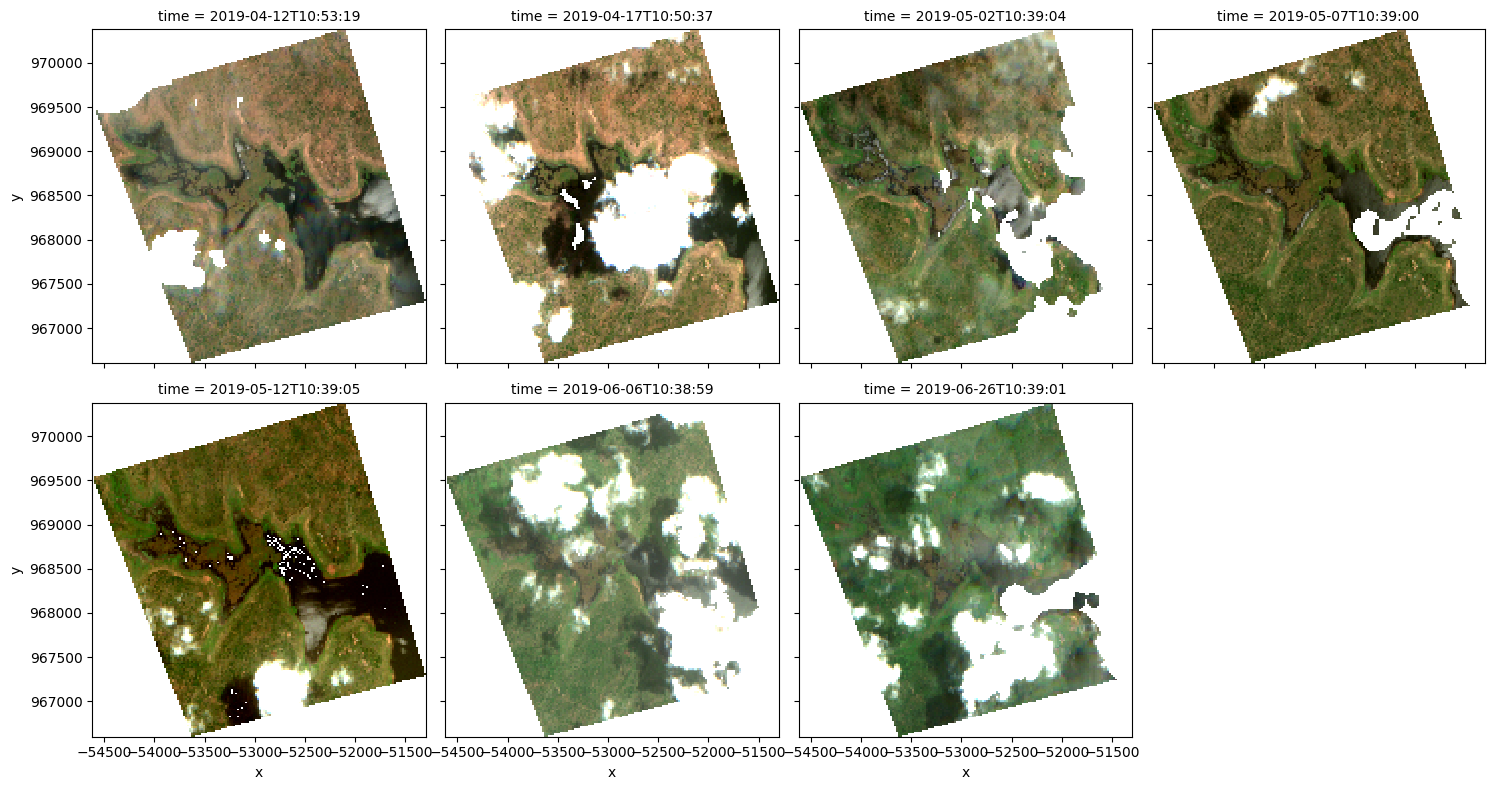

In [10]:
rgb(results[key], col='time', size=4)

### Calculate NDVI and plot
We can also apply analyses to data loaded for each of our polygons.
For example, we can calculate the normalised difference vegetation index (NDVI) to identify areas of growing vegetation.

> **Note**: NDVI can be calculated using the [calculate_indices](../Frequently_used_code/Calculating_band_indices.ipynb) function, imported from [deafrica_tools.bandindices](../Tools/deafrica_tools/bandindices.py).
Here, we use `satellite_mission='s2'` since we are working with Sentinel-2 data.

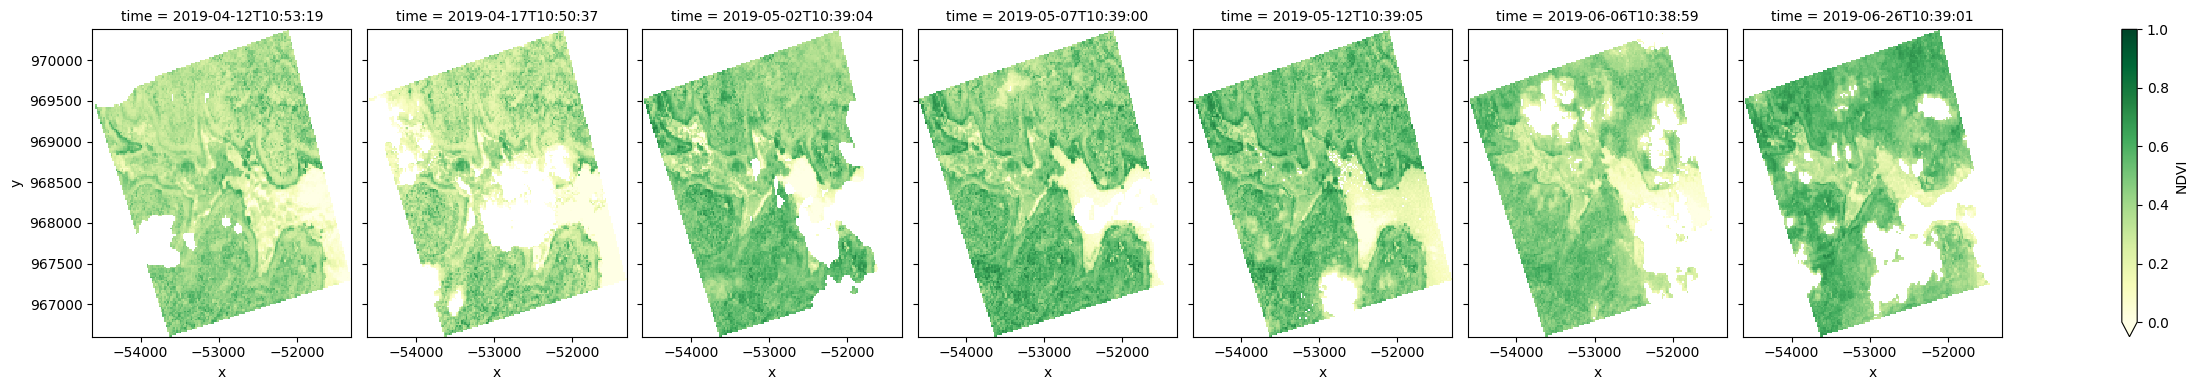

In [11]:
# Calculate band index
ndvi = calculate_indices(results[key], index='NDVI', satellite_mission='s2')
        
# Plot NDVI for each polygon for the time query
ndvi.NDVI.plot(col='time', cmap='YlGn', vmin=0.0, vmax=1, figsize=(25, 4))
plt.show()

---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:**

In [12]:
print(datacube.__version__)

1.8.12


**Last Tested:**

In [13]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2023-03-30'